# JDOT Domain Adaptation with Gaussian Distributions

In [155]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing
import ot

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the dataset

In [3]:
lb = preprocessing.LabelBinarizer()

### Source domain

In [34]:
N_source = [50, 50, 50] # number of points for the 2 classes

In [35]:
mean = 1*np.array([[-1,-1], [-1,1], [1,0]])
std = 0.1

In [36]:
X = []
X_source = np.concatenate([ot.datasets.get_2D_samples_gauss(N_source[i], mean[i], std) 
                           for i in range(len(N_source))], axis=0)

Y_source = np.concatenate([[i]*N_source[i] for i in range(len(N_source))])
Y_source_bin = lb.fit_transform(Y_source)

### Target domain

In [37]:
N_target = [60, 60, 60] # number of points for the 2 classes

In [38]:
angle = np.pi/4
rot_matrix = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
mean = np.dot(rot_matrix, mean.T).T
std = 0.1

In [39]:
X = []
X_target = np.concatenate([ot.datasets.get_2D_samples_gauss(N_target[i], mean[i], std) 
                           for i in range(len(N_target))], axis=0)

Y_target = np.concatenate([[i]*N_target[i] for i in range(len(N_target))])
Y_target_bin = lb.fit_transform(Y_target)

### Label binarization

### Display the dataset

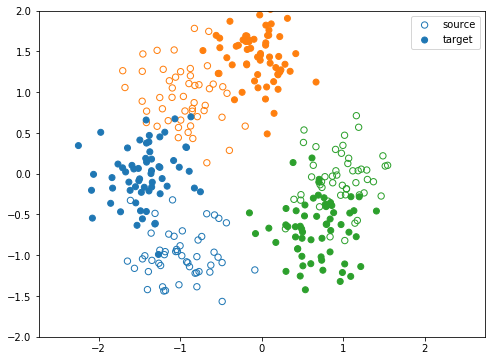

In [40]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.axis("equal")
plt.axis([-2,2,-2,2])

plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])
plt.legend()

## Initialization

### Model for the classifier

In [156]:
model = Sequential()
model.add(Dense(3, activation="softmax", input_dim=2))
model.compile('adam','categorical_crossentropy')

In [170]:
model.fit(X_source, Y_source_bin, epochs=500, verbose=0)

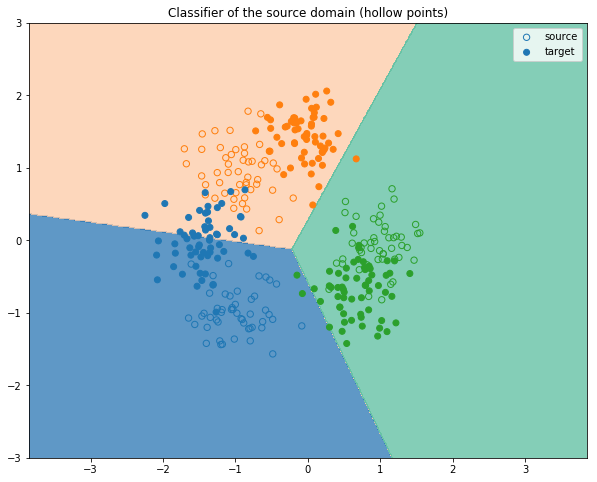

In [171]:
from matplotlib import colors

plt.rcParams['figure.figsize'] = (10, 8)
plt.axis("equal")
plt.axis(3*np.array([-1,1,-1,1]))

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

cm = colors.ListedColormap([plt.cm.Set1(1), plt.cm.Pastel2(1), plt.cm.Set2(0)])
Z = lb.inverse_transform(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
cont = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

plt.title("Classifier of the source domain (hollow points)")
plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])
plt.legend()

In [172]:
def f(x):
    return model.predict(x.reshape(1,-1)).flatten()

### Label loss function

In [173]:
def label_loss(y, fx):
    if len(fx) == 1:
        fx = lb.transform(fx)
    fx = fx.flatten()
    return np.sum([y[i_class] * (1-fx[i_class])**2 + (1 - y[i_class]) * (-1 - fx[i_class])**2 
                   for i_class in range(len(y))])

### Hyperparameters

In [174]:
alpha = 1
batch_size = 50

a = np.ones((len(Y_source),)) / len(Y_source)
b = np.ones((len(Y_target),)) / len(Y_target)
wa = np.ones((batch_size),) / batch_size
wb = np.ones((batch_size),) / batch_size

## Run the algorithm

In [175]:
f(np.array([-0.59526221, -1.09912641]))

array([ 0.99054784,  0.00281169,  0.00664049], dtype=float32)

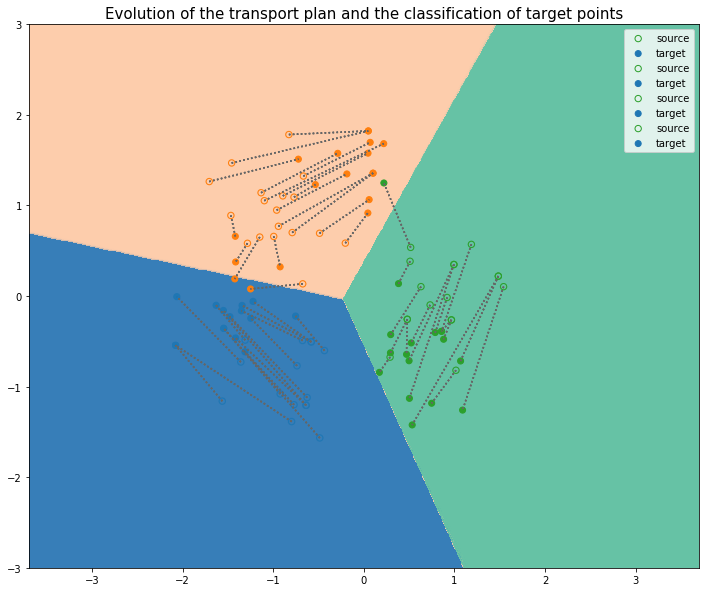

In [188]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.axis("equal")
plt.axis(3*np.array([-1,1,-1,1]))

nb_iter = 4
nb_batch_iter = 1
for i_batch in range(nb_batch_iter):
    # Mini-batch choice
    source_choice = np.random.choice(len(Y_source), batch_size)
    target_choice = np.random.choice(len(Y_target), batch_size)
    X_sample_source = X_source[source_choice]
    Y_sample_source = Y_source[source_choice]
    Y_sample_source_bin = Y_source_bin[source_choice]
    X_sample_target = X_target[target_choice]
    
    for i in range(nb_iter):
        # Gamma part: learn a transport plan
        D = np.array([[np.linalg.norm(xs-xt) for xt in X_sample_target] for xs in X_sample_source])
        L = np.array([[label_loss(ys, f(xt)) for xt in X_sample_target] for ys in Y_sample_source_bin])
        C = alpha * D + L
        gamma = ot.emd(wa, wb, C)

        # f part: learn 
        Y_hat = len(Y_sample_source) * gamma.T.dot(Y_sample_source)
        Y_hat_bin = (1. / len(Y_sample_source)) * np.dot(gamma.T, Y_sample_source_bin)
        Y_hat = lb.inverse_transform(Y_hat_bin)
        model.fit(X_sample_target, Y_hat_bin, epochs=100, verbose=0)

        # Plot
        Z = lb.inverse_transform(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
        cont = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        plt.scatter(X_sample_source[:,0], X_sample_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_sample_source])
        plt.scatter(X_sample_target[:,0], X_sample_target[:,1], label="target", color=colormap[Y_hat])
        ot.plot.plot2D_samples_mat(X_sample_source, X_sample_target, gamma, color=plt.cm.Dark2(8), linestyle=":")
        plt.title("Evolution of the transport plan and the classification of target points", fontsize=15)
        plt.legend()

        #plt.savefig("screenshots/gaussian-13.png")

## Interesting information

/home/artix41/miniconda3/envs/ml-cpu/lib/python3.5/site-packages/ot/lp/__init__.py:98: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


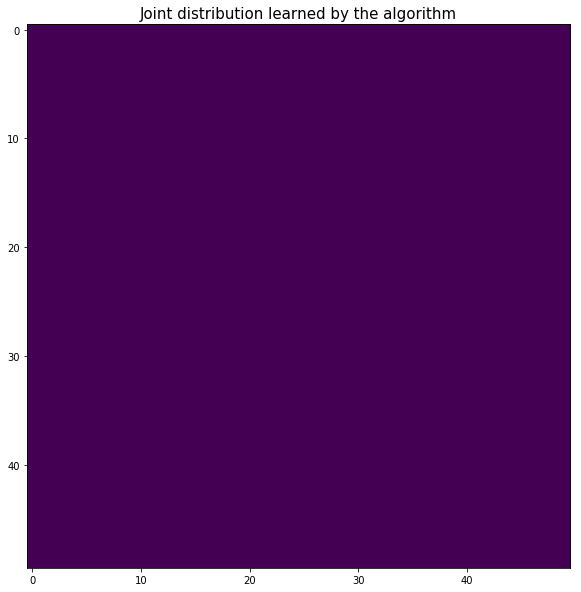

In [71]:
gamma = ot.emd(a, b, C)
plt.imshow(gamma, interpolation='nearest')
plt.title("Joint distribution learned by the algorithm", fontsize=15)